# Задача 1: Baseline model

На сайте https://russia.duck.consulting/ можно найти множество статистических данных по регионам России.

Все нижеиспользуемые датасеты были взяты оттуда.

In [1008]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

from sklearn import metrics

from pandas_profiling import ProfileReport

In [1009]:
# Импортируем датасет, содержащий информацию об экономических преступлениях
# crimes - количество преступлений на 10.000 жителей

df_ec_crimes = pd.read_csv('ec_crimes.csv')
df_ec_crimes.columns = ['year', 'region', 'crimes']

In [1010]:
# Импортируем датасет с информацией об уровне безработицы
# unemployments - безработица в процентах

df_unemp = pd.read_csv('unemployments.csv')
df_unemp.columns = ['year', 'region', 'unemployments']

In [1011]:
# Импортируем датасет с информацией о среднем заработке россиян

df_avg_salary = pd.read_csv('avg_salary.csv')
df_avg_salary.columns = ['year', 'region', 'avg_salary']


In [1012]:
# Соединяем вышеперечисленные датасеты в один по региону и году

df = pd.merge(df_ec_crimes, df_avg_salary, on=['region', 'year'])

In [1013]:
df = pd.merge(df, df_unemp, on=['region', 'year'])

In [1014]:
# Удаляем строки с NaN

df = df.dropna()

In [1015]:
# Итоговый датасет

df

,year,region,crimes,avg_salary,unemployments
0,2009,Адыгея,15.77,10798.0,7.7
1,2009,Алтайский край,15.02,10741.0,12.3
2,2009,Амурская область,19.17,17969.0,8.3
3,2009,Архангельская область,28.30,17654.0,7.2
4,2009,Астраханская область,102.89,14011.0,9.9
5,2009,Башкортостан,26.90,15127.0,9.2
6,2009,Белгородская область,29.04,13712.0,4.7
7,2009,Брянская область,31.12,10541.0,10.7
8,2009,Бурятия,32.06,16140.0,13.7
9,2009,Владимирская область,24.71,13199.0,8.7


In [1016]:
TRAIN_PERCENT = int(df.shape[0]*0.66) #указывает размер обучающей выборки
df_train = df[:TRAIN_PERCENT]
df_test = df[TRAIN_PERCENT:]

In [1017]:
# Выводим статистическую информацию о данных

profile = ProfileReport(df, title='Pandas Profiling Report')
profile

На основе информации о корреляциии между стобцами (вкладка 'Correlations' в ячейке выше), можно сделать вывод, что на качество обучения больше всего будет влиять информация о среднем заработке россиян (самая высокая корреляция м/у crimes и avg_salary).

In [1018]:
features_orig = ['unemployments', 'avg_salary']

features = features_orig

In [1019]:
# Разделяем датасет на обучающую и тестовую выборку

X_train = df_train[features]
y_train = df_train['crimes']

X_test = df_test[features]
y_test = df_test['crimes']

In [1020]:
def get_regression_metrics(model, actual, predicted):
    
    """Calculate main regression metrics.
    
    Args:
        model (str): The model name identifier
        actual (series): Contains the test label values
        predicted (series): Contains the predicted values
        
    Returns:
        dataframe: The combined metrics in single dataframe
    
    
    """
    regr_metrics = {
                        'Root Mean Squared Error' : metrics.mean_squared_error(actual, predicted)**0.5,
                        'Mean Absolute Error' : metrics.mean_absolute_error(actual, predicted),
                   }

    #return reg_metrics
    df_regr_metrics = pd.DataFrame.from_dict(regr_metrics, orient='index')
    df_regr_metrics.columns = [model]
    return df_regr_metrics

In [1021]:
def plot_features_weights(model, weights, feature_names, weights_type='c'):
    
    """Plot regression coefficients weights or feature importance.
    
    Args:
        model (str): The model name identifier
        weights (array): Contains the regression coefficients weights or feature importance
        feature_names (list): Contains the corresponding features names
        weights_type (str): 'c' for 'coefficients weights', otherwise is 'feature importance'
        
    Returns:
        plot of either regression coefficients weights or feature importance
        
    
    """
    (px, py) = (8, 10) if len(weights) > 30 else (8, 5)
    W = pd.DataFrame({'Weights':weights}, feature_names)
    W.sort_values(by='Weights', ascending=True).plot(kind='barh', color='r', figsize=(px,py))
    label = ' Coefficients' if weights_type =='c' else ' Features Importance'
    plt.xlabel(model + label)
    plt.gca().legend_ = None

In [1022]:
def plot_residual(model, y_train, y_train_pred, y_test, y_test_pred):
    
    """Print the regression residuals.
    
    Args:
        model (str): The model name identifier
        y_train (series): The training labels
        y_train_pred (series): Predictions on training data
        y_test (series): The test labels
        y_test_pred (series): Predictions on test data
        
    Returns:
        Plot of regression residuals
    
    """
    
    plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label='Training data')
    plt.scatter(y_test_pred, y_test_pred - y_test, c='lightgreen', marker='s', label='Test data')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=-50, xmax=400, color='red', lw=2)
    plt.title(model + ' Residuals')
    plt.show()

In [1023]:
# Линейная регрессия

linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

y_test_predict = linreg.predict(X_test)
y_train_predict = linreg.predict(X_train)

print('MAE training: %.3f, MAE test: %.3f' % (
      (metrics.mean_absolute_error(y_train, y_train_predict)), 
      (metrics.mean_absolute_error(y_test, y_test_predict))))

linreg_metrics_orig_features = get_regression_metrics('Linear Regression (Baseline model)', y_test, y_test_predict)
linreg_metrics_orig_features

MAE training: 7.638, MAE test: 7.192


,Linear Regression (Baseline model)
Root Mean Squared Error,7.736462
Mean Absolute Error,7.191700


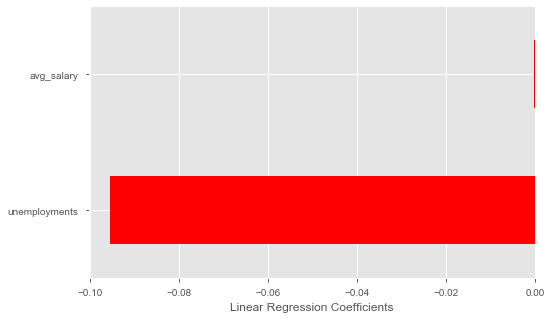

In [1024]:
plot_features_weights('Linear Regression', linreg.coef_, X_train.columns, 'c')

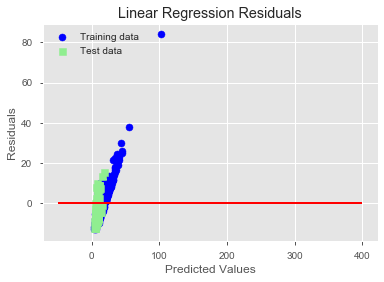

In [1025]:
plot_residual('Linear Regression', y_train_predict, y_train, y_test_predict, y_test)

In [1026]:
# Полиномиальная регрессия

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)


polyreg = linear_model.LinearRegression()
polyreg.fit(X_train_poly, y_train)

y_test_predict = polyreg.predict(X_test_poly)
y_train_predict = polyreg.predict(X_train_poly)

print('MAE training: %.3f, MAE test: %.3f' % (
      (metrics.mean_absolute_error(y_train, y_train_predict)), 
      (metrics.mean_absolute_error(y_test, y_test_predict))))

polyreg_metrics_orig_features = get_regression_metrics('Polynomial Regression (Baseline model)', y_test, y_test_predict)
polyreg_metrics_orig_features

MAE training: 6.983, MAE test: 5.912


,Polynomial Regression (Baseline model)
Root Mean Squared Error,6.970057
Mean Absolute Error,5.911603


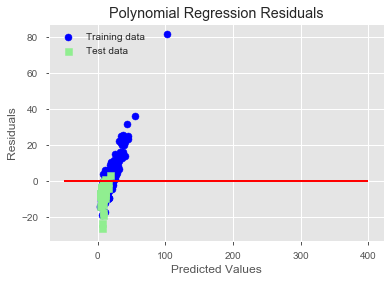

In [1027]:
plot_residual('Polynomial Regression', y_train_predict, y_train, y_test_predict, y_test)


In [1028]:
# Сравним реальные и предсказанные значения (Плиномиальная регрессия)

pr_pred_dict = {
                'Actual' : y_test,
                'Prediction' : y_test_predict
            }
    
pr_pred = pd.DataFrame.from_dict(pr_pred_dict).T
pr_pred

,275,276,277,278,279,280,281,282,283,284,...,408,409,410,411,412,413,414,415,416,417
Actual,8.230000,8.730000,7.240000,6.71000,4.460000,6.460000,5.83000,4.750000,6.110000,12.490000,...,6.140000,5.230000,6.310000,7.89000,4.400000,8.350000,6.420000,5.170000,6.870000,5.130000
Prediction,13.798437,13.650255,12.239641,10.00498,15.878952,15.643872,12.81996,10.292876,11.679655,13.346132,...,9.574055,10.029982,15.768143,10.88799,18.164988,12.823204,29.661713,12.950308,33.215473,11.389977


In [1029]:
# Сравним итоговые результаты

reg_metrics_bfe = pd.concat([linreg_metrics_orig_features, polyreg_metrics_orig_features], axis=1)
reg_metrics_bfe

,Linear Regression (Baseline model),Polynomial Regression (Baseline model)
Root Mean Squared Error,7.736462,6.970057
Mean Absolute Error,7.191700,5.911603


# Задача 2: User model

За целевую переменную я так же взял уровень преступности,
добавил  независимые переменные:
- интегрированная оценка качества жизни
- процент бедного населения


In [1030]:
# Датасет с интегрированной оценкой качества жизни населения

df_q = pd.read_csv('life_quality.csv')
df_q.columns = ['year', 'region', 'life_quality']

In [1031]:
# Датасет с процентом бедного населения

df_p = pd.read_csv('percentage_of_poor.csv')
df_p.columns = ['year', 'region', 'poor']

In [1032]:
# Соединяем датасеты

df = pd.merge(df, df_q, on=['region', 'year'])

In [1033]:
df = pd.merge(df, df_p, on=['region', 'year'])

In [1034]:
df = df.dropna()

In [1035]:
df

,year,region,crimes,avg_salary,unemployments,life_quality,poor
0,2013,Адыгея,13.50,18398.0,7.9,40.66,12.0
1,2013,Алтайский край,6.70,17558.0,8.3,36.40,17.6
2,2013,Амурская область,4.36,29148.0,6.1,35.15,15.1
3,2013,Архангельская область,8.99,29228.0,6.1,36.85,13.9
4,2013,Астраханская область,13.49,21293.0,7.5,40.91,12.0
5,2013,Башкортостан,5.16,23938.0,5.8,46.29,10.4
6,2013,Белгородская область,8.17,22156.0,4.0,54.96,7.4
7,2013,Брянская область,10.16,18842.0,5.2,40.98,11.7
8,2013,Бурятия,5.63,26545.0,8.0,30.66,15.9
9,2013,Владимирская область,10.52,20889.0,3.8,44.69,13.5


In [1036]:
# Выводим статистическую информацию о данных

profile = ProfileReport(df, title='Pandas Profiling Report')
profile

In [1037]:
TRAIN_PERCENT = int(df.shape[0]*0.66) #указывает размер обучающей выборки
df_train = df[:TRAIN_PERCENT]
df_test = df[TRAIN_PERCENT:]

In [1038]:
columns_for_analysis = ['life_quality', 'poor', 'crimes']

clmns = columns_for_analysis

In [1039]:
# remove outliers

df_train = df_train[clmns][df_train[clmns].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
df_test = df_test[clmns][df_test[clmns].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]


In [1040]:
features_orig = ['unemployments', 'avg_salary']

features_another = ['life_quality', 'poor']

features = features_another

In [1041]:
# Разделяем датасет на обучающую и тестовую выборку

X_train = df_train[features]
y_train = df_train['crimes']

X_test = df_test[features]
y_test = df_test['crimes']

In [1042]:
# Линейная регрессия

linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

y_test_predict = linreg.predict(X_test)
y_train_predict = linreg.predict(X_train)

print('MAE training: %.3f, MAE test: %.3f' % (
      (metrics.mean_absolute_error(y_train, y_train_predict)), 
      (metrics.mean_absolute_error(y_test, y_test_predict))))

linreg_metrics_new_features = get_regression_metrics('Linear Regression (User Model)', y_test, y_test_predict)
linreg_metrics_new_features

MAE training: 2.213, MAE test: 1.840


,Linear Regression (User Model)
Root Mean Squared Error,2.128943
Mean Absolute Error,1.840393


In [1043]:
# Полиномиальная регрессия

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)


polyreg = linear_model.LinearRegression()
polyreg.fit(X_train_poly, y_train)

y_test_predict = polyreg.predict(X_test_poly)
y_train_predict = polyreg.predict(X_train_poly)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

polyreg_metrics_new_features = get_regression_metrics('Polynomial Regression (User Model)', y_test, y_test_predict)
polyreg_metrics_new_features

R^2 training: 0.063, R^2 test: -0.734


,Polynomial Regression (User Model)
Root Mean Squared Error,2.267243
Mean Absolute Error,1.926573


In [1044]:
# Random Forest

rf = RandomForestRegressor(n_estimators=100, max_depth=6, n_jobs=-1, random_state=1)

rf.fit(X_train, y_train)

y_test_predict = rf.predict(X_test)
y_train_predict = rf.predict(X_train)

print('MAE training: %.3f, MAE test: %.3f' % (
      (metrics.mean_absolute_error(y_train, y_train_predict)), 
      (metrics.mean_absolute_error(y_test, y_test_predict))))

rf_metrics = get_regression_metrics('Random Forest Regression (User Model)', y_test, y_test_predict)
rf_metrics

MAE training: 1.443, MAE test: 1.765


,Random Forest Regression (User Model)
Root Mean Squared Error,2.164368
Mean Absolute Error,1.764618


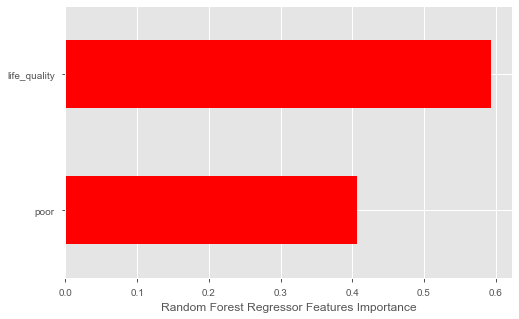

In [1045]:
plot_features_weights('Random Forest Regressor', rf.feature_importances_, X_train.columns, 't' )


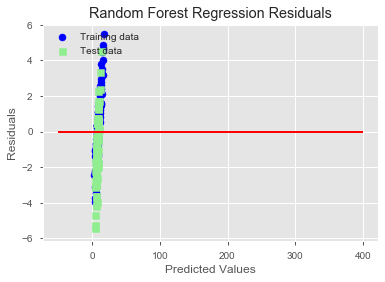

In [1046]:
plot_residual('Random Forest Regression', y_train_predict, y_train, y_test_predict, y_test)


In [1047]:
# Сравним реальные и предсказанные значения

rf_pred_dict = {
                'Actual' : y_test,
                'Prediction' : y_test_predict
            }
    
rf_pred = pd.DataFrame.from_dict(rf_pred_dict).T
rf_pred

,166,167,168,170,171,172,173,174,175,176,...,243,244,245,246,247,248,249,250,251,252
Actual,7.11000,5.140000,6.510000,6.220000,8.840000,9.060000,5.440000,5.040000,5.010000,8.52000,...,6.140000,5.230000,6.310000,7.890000,4.400000,8.350000,6.420000,5.170000,6.870000,5.130000
Prediction,8.63384,7.503627,7.849115,8.842844,8.244401,8.879059,8.033247,7.363915,9.200889,10.51278,...,7.984384,8.861252,6.508758,7.228935,9.086373,8.357695,8.039452,8.782781,8.587762,7.274364


In [1048]:
# Также я поробовал использовать XGBoost (до я с ним не работал), варьируя гиперпараметры, получилось добиться приемлимого результата

xgdmat=xgb.DMatrix(X_train,y_train)
our_params={'learning_rate':0.2, 'subsample':0.8, 'max_depth':6}
final_gb=xgb.train(our_params,xgdmat)
tesdmat=xgb.DMatrix(X_test)
y_pred=final_gb.predict(tesdmat)

In [1049]:
xg_metrics = get_regression_metrics('XGBoost (User Model)', y_test, y_pred)
xg_metrics

,XGBoost (User Model)
Root Mean Squared Error,1.888637
Mean Absolute Error,1.467986


In [1050]:
xg_pred_dict = {
                'Actual' : y_test,
                'Prediction' : y_pred
            }
    
xg_pred = pd.DataFrame.from_dict(xg_pred_dict).T
xg_pred

,166,167,168,170,171,172,173,174,175,176,...,243,244,245,246,247,248,249,250,251,252
Actual,7.110000,5.140000,6.510000,6.220000,8.840000,9.060000,5.440000,5.040000,5.010000,8.520000,...,6.140000,5.230000,6.31000,7.890000,4.400000,8.350000,6.420000,5.170000,6.870000,5.130000
Prediction,8.272806,6.301579,7.172981,7.431869,6.773447,7.548676,6.832881,6.647979,7.824203,7.674354,...,7.327531,7.548676,5.84839,5.453695,7.820765,7.476546,7.205287,8.105257,7.370532,6.180288


In [1051]:
# Сравним итоговые результаты

reg_metrics_bfe = pd.concat([linreg_metrics_orig_features, polyreg_metrics_orig_features, linreg_metrics_new_features, polyreg_metrics_new_features, rf_metrics, xg_metrics], axis=1)
reg_metrics_bfe

,Linear Regression (Baseline model),Polynomial Regression (Baseline model),Linear Regression (User Model),Polynomial Regression (User Model),Random Forest Regression (User Model),XGBoost (User Model)
Root Mean Squared Error,7.736462,6.970057,2.128943,2.267243,2.164368,1.888637
Mean Absolute Error,7.191700,5.911603,1.840393,1.926573,1.764618,1.467986


Выводы: Лучше всего предсказывает уровень преступности модель XGBoost, используя данные об интгрированной оценке уровня жизни и информацию об уровни бедности. Сравнимые результаты показала модель Random Forest.